In [ ]:
import torch;
import torchvision;
import torchvision.transforms as T;
import torch.nn as nn;
from torch.utils.data import Dataset;
from torch.utils.data import DataLoader;
import cv2 as cv;
from PIL import Image;
import matplotlib.pyplot as plt;
import pickle;
import numpy as np;
import os;

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");

In [ ]:
print(device);
print(os.getcwd());

cuda:0
/home/student/ImageColorization


In [ ]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding,down=True,sig=False):
        super(Block,self).__init__();

        self.main = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)\
            if down else nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels) if not sig else nn.Identity(),
            (nn.LeakyReLU(0.2,inplace=False) if down else nn.ReLU(inplace=False)) if not sig else nn.Sigmoid()
        );
    def forward(self,x):
        return self.main(x);

In [ ]:
class GEN(nn.Module):
    def __init__(self):
        super(GEN,self).__init__();

        self.conv1 = Block(1,64,4,2,1);     #128
        self.conv2 = Block(64,128,4,2,1);   #64
        self.conv3 = Block(128,256,4,2,1);  #32
        self.conv4 = Block(256,512,4,2,1);  #16
        self.conv5 = Block(512,1024,4,2,1); #8
        self.conv6 = Block(1024,2048,4,2,1);#4
        self.conv7 = Block(2048,4096,4,2,1);#2


        self.deconv7 = Block(4096,2048,4,2,1,down=False);
        self.deconv6 = Block(4096,1024,4,2,1,down=False);
        self.deconv5 = Block(2048,512,4,2,1,down=False);
        self.deconv4 = Block(1024,256,4,2,1,down=False);
        self.deconv3 = Block(512,128,4,2,1,down=False);
        self.deconv2 = Block(256,64,4,2,1,down=False);
        self.deconv1 = nn.Sequential(
                nn.ConvTranspose2d(128,2,4,2,1,bias=False),
                nn.Tanh()
            );

    def forward(self,x):
        x_1 = self.conv1(x);   #128
        x_2 = self.conv2(x_1); #64
        x_3 = self.conv3(x_2); #32
        x_4 = self.conv4(x_3); #16
        x_5 = self.conv5(x_4); #8
        x_6 = self.conv6(x_5); #4
        x_7 = self.conv7(x_6); #2

        x_7 = self.deconv7(x_7);                        #4

        x_6 = self.deconv6(torch.cat((x_6,x_7),dim=1)); #8
        x_5 = self.deconv5(torch.cat((x_5,x_6),dim=1)); #16
        x_4 = self.deconv4(torch.cat((x_4,x_5),dim=1)); #32
        x_3 = self.deconv3(torch.cat((x_3,x_4),dim=1)); #64
        x_2 = self.deconv2(torch.cat((x_2,x_3),dim=1)); #128
        x_1 = self.deconv1(torch.cat((x_1,x_2),dim=1)); #256

        return x_1;

In [ ]:
class DIS(nn.Module):
    def __init__(self):
        super(DIS,self).__init__();
        self.main = nn.Sequential(
            Block(3,64,4,2,1,down=True),            #128
            Block(64,128,4,2,1,down=True),          #64
            Block(128,256,4,2,1,down=True),         #32
            Block(256,512,3,1,0,down=True),         #32-3+1 = 30
            Block(512,1,3,1,1,down=True,sig=True)   #30-3+2+1 = 30
        );

    def forward(self,x,y):
        x = torch.concat((x,y),dim=1);
        return self.main(x);

In [ ]:
netG = pickle.load(open('gen.pkl','rb'));
netD = pickle.load(open('dis.pkl','rb'));

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.path = 'imageColorization/TOM_AND_JERRY';
        self.files = os.listdir(self.path);
        self.transform = T.Compose([
            T.Resize((256,256)),
            T.ToTensor()
        ]);

    def __len__(self):
        return len(self.files);

    def __getitem__(self,idx):
        x = Image.open(os.path.join(self.path,self.files[idx]));
        x = Image.fromarray(cv.cvtColor(np.array(x),cv.COLOR_RGB2LAB));
        x = self.transform(x);
        return x[0].unsqueeze(dim=0),x[1:3];


In [ ]:
dataset = CustomDataset();

torch.Size([1, 256, 256])
torch.Size([2, 256, 256])


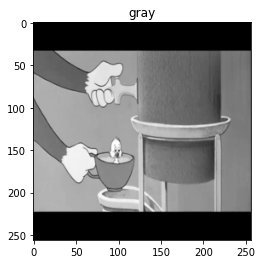

In [ ]:
print(dataset[1][0].shape);
print(dataset[1][1].shape);

plt.figure();
plt.imshow(T.ToPILImage()(dataset[1][0]),cmap='gray');
plt.title('gray');

In [ ]:
data_loader = DataLoader(dataset,batch_size = 8,shuffle=True);

In [ ]:
netG = netG.to(device);
netD = netD.to(device);

criterion = nn.BCELoss();

optimizerG = torch.optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999));
optimizerD = torch.optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5,0.999));

In [ ]:
torch.autograd.set_detect_anomaly(True)
epochs = 5;

for epoch in range(epochs):
    for i,data in enumerate(data_loader,0):
        optimizerD.zero_grad();
        d_size = data[0].size(0);

        x = data[0].to(device);  # L Channel
        y = data[1].to(device);  # ab Channel

        output = netD(x,y);
        d_x = output.view(-1).mean().item();

        errD_real = criterion(output.view(-1),torch.ones_like(output.view(-1),device=device));
        errD_real.backward();

        fake = netG(x);

        output = netD(x,fake.detach());
        errD_fake = criterion(output.view(-1),torch.zeros_like(output.view(-1),device=device));
        errD_fake.backward();

        optimizerD.step();

        optimizerG.zero_grad();
        output = netD(x,fake);
        D_G_z = output.view(-1).mean().item();

        errG = criterion(output.view(-1),torch.ones_like(output.view(-1),device=device));
        errG.backward(retain_graph=True);

        l1_error = 100 * torch.mean(torch.abs(fake.view(-1).clone() - y.view(-1)));
        l1_error.backward();
        optimizerG.step();

        if i % 50 == 0:
            print(f"[{i}/{len(data_loader)}][{epoch}/{epochs}] : D(x): {d_x:.4f}  D(G(z)): {D_G_z:.4f}");

[0/406][0/5] : D(x): 0.9996  D(G(z)): 0.0001
[50/406][0/5] : D(x): 0.9997  D(G(z)): 0.0303
[100/406][0/5] : D(x): 0.9991  D(G(z)): 0.0001
[150/406][0/5] : D(x): 0.9986  D(G(z)): 0.0012
[200/406][0/5] : D(x): 0.9996  D(G(z)): 0.0001
[250/406][0/5] : D(x): 0.9997  D(G(z)): 0.0004
[300/406][0/5] : D(x): 0.9997  D(G(z)): 0.0007
[350/406][0/5] : D(x): 0.9996  D(G(z)): 0.0015
[400/406][0/5] : D(x): 0.9996  D(G(z)): 0.0001
[0/406][1/5] : D(x): 0.9997  D(G(z)): 0.0012


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 11.91 GiB total capacity; 7.19 GiB already allocated; 170.81 MiB free; 8.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

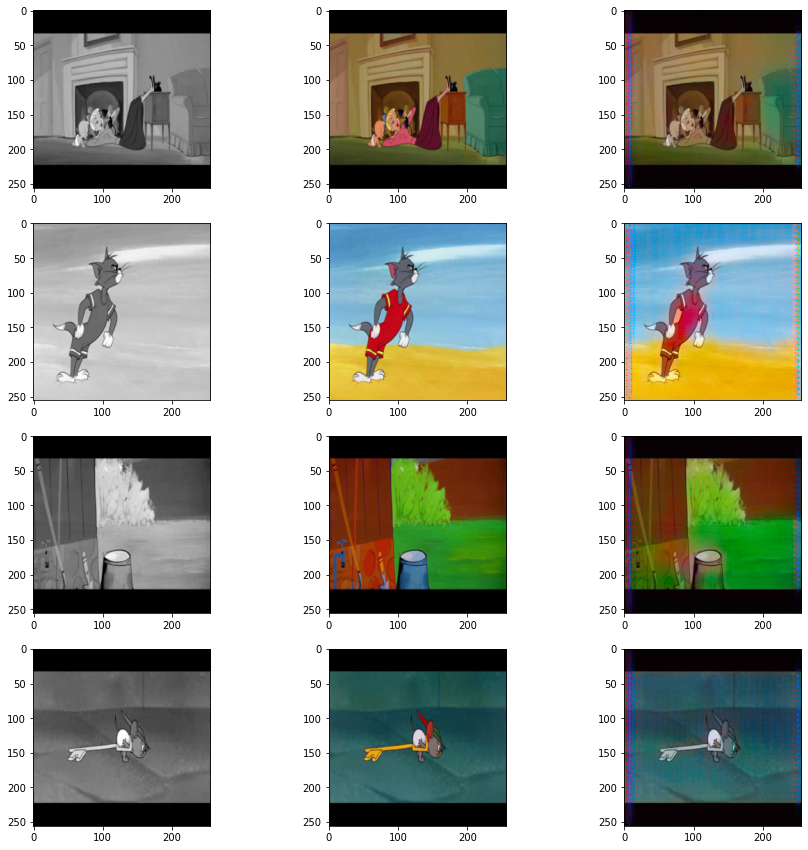

In [ ]:
imgs = next(iter(data_loader));

gray_channel = imgs[0];
ab_channel = imgs[1];

fake_ab_channel = netG(gray_channel.to(device));

fig,ax = plt.subplots(4,3);
fig.set_figwidth(15);
fig.set_figheight(15);

for i in range(4):
    gray = gray_channel[i];
    ab = ab_channel[i];
    fake_ab = fake_ab_channel[i];

    toPIL = torchvision.transforms.ToPILImage();

    gray_img = toPIL(gray);
    real_img = np.array(toPIL(torch.concat((gray,ab),dim=0)));
    fake_img = np.array(toPIL(torch.concat((gray,fake_ab.detach().cpu()),dim=0)));

    real_img = cv.cvtColor(real_img,cv.COLOR_LAB2RGB);
    fake_img = cv.cvtColor(fake_img,cv.COLOR_LAB2RGB);

    ax[i][0].imshow(gray_img,cmap='gray');
    ax[i][1].imshow(real_img);
    ax[i][2].imshow(fake_img);


In [ ]:
import pickle;
pickle.dump(netG,open('gen_of_tom_jerry.pkl','wb'));
pickle.dump(netD,open('dis_of_tom_jerry.pkl','wb'));